In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math

In [2]:
def temperature(t, offset = 0): # Temperature function in kelvin
    return (4*np.cos(2*np.pi*(t + offset)/365.25 + 9.2) + 28.0) + 273.15
    
def temperature_const(t,offset = 0): # Constant temperature
    return 273.15 + 28.0

def humidity(t, offset = 0): # Humidity function in percent
    return 60 #+ 30*np.cos(6*np.pi*(t + offset)/365.25 + 9.2) + 10*np.cos(8*np.pi*(t + offset)/365.25 + 9.2)

def transition_rate(evt, T, R0, Ha, Hh, T12, R): # Transition rate function from one state to another
    return R0[evt]*(T/298)*np.exp(Ha[evt]*(1/298 - 1/T)/R)/(1 + np.exp(Hh[evt]*(1/T12[evt] - 1/T)/R))

def adult_rate(T, R0, Ha, Hh, T12, R): # Transition rate function from larvae to pupae to adult
    egg_transi = transition_rate(0, T, R0, Ha, Hh, T12, R)
    larvae_transi = transition_rate(1, T, R0, Ha, Hh, T12, R)
    pupae_transi = transition_rate(2, T, R0, Ha, Hh, T12, R)
    death_L = 0.01 + 0.9725*np.exp(-0.1*(T - 278)/2.7035)
    death_P = 0.01 + 0.9725*np.exp(-0.1*(T - 278)/2.7035)

    return egg_transi*larvae_transi*pupae_transi/((pupae_transi + death_P) * (larvae_transi + death_L))

# definition of the different mortality rates : 
def egg_death(T) : 
    if T < 288 : 
        return 0
    else :
        return 0.011 # A calculer

In [14]:
def mating(M, Ms):
    return M / (1 + M + Ms)

def event(i, state, M_event):
    return state + M_event[i]

def release1(M, n):
    return n*M + 2000

def competition(K0, Kh, precip):
    return 1/(K0 + Kh *  precip)

In [4]:
#open the meteorological data
import pandas as pd
meteo_df = pd.read_csv('../Data/meteo_tetiaroa_resampled.csv')
print("Columns in meteo_df:", meteo_df.columns)

precip_data = meteo_df['precip2'].values
temperature_data = meteo_df['TM'].values

Columns in meteo_df: Index(['time', 'TM', 'precip2'], dtype='object')


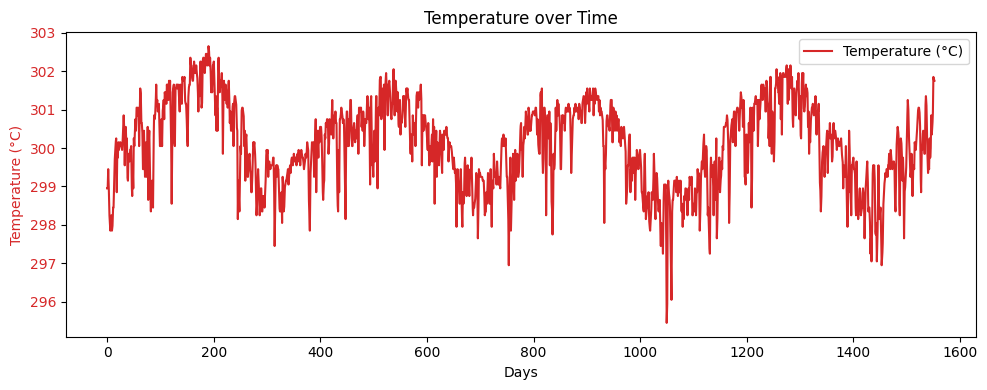

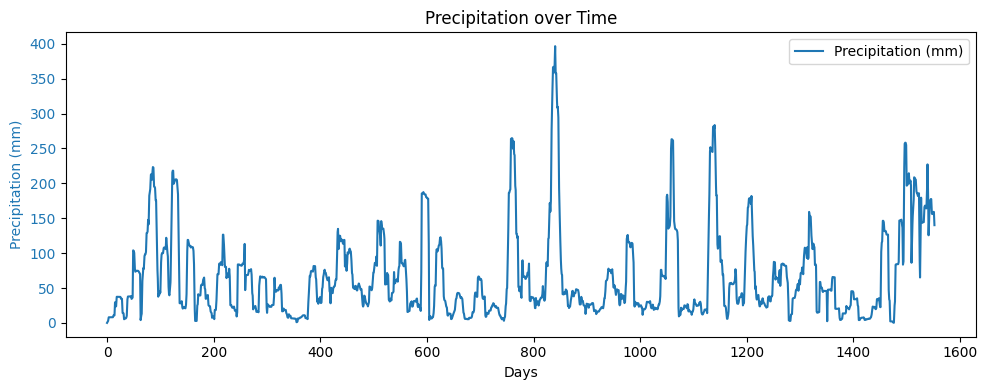

In [24]:
# Plot temperature and precipitation in two separate graphs
fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(days, temperature_data + 273.15, label='Temperature (°C)', color='tab:red')
ax1.set_xlabel('Days')
ax1.set_ylabel('Temperature (°C)', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_title('Temperature over Time')
plt.legend()
plt.tight_layout()
plt.show()

fig, ax2 = plt.subplots(figsize=(10, 4))
ax2.plot(days, precip_data, label='Precipitation (mm)', color='tab:blue')
ax2.set_xlabel('Days')
ax2.set_ylabel('Precipitation (mm)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_title('Precipitation over Time')
plt.legend()
plt.tight_layout()
plt.show()

# Population model

In [29]:
def det_model(y, t, birth, n_egg, deltaA, comp, mu, R0, Ha, Hh, T12, R, temperature_data, precip_data):
    E, F, Ff, Fs, M, Ms = y

    #T = temperature(t)
    #T = temperature_const(t)
    T = temperature_data[int(t*100001/1552)-1] + 273.15
    precip = precip_data[int(t*100001/1552)-1]

    Hum = humidity(t)

    if T < 276:
        death_egg = 0.001
        transi = 0
        deltaA = 2 * deltaA

    else:
        transi = adult_rate(T, R0, Ha, Hh, T12, R)
        death_egg = egg_death(T) + competition(1/comp, 1/(comp * 30), precip) * E + (transition_rate(0, T, R0, Ha, Hh, T12, R) - transi)
        deltaA = 0.091
    if M + Ms == 0:
        probaM = 0
        probaMs = 0
    else:
        probaM = 2 * M / (2 * M + Ms)
        probaMs = Ms / (2 * M + Ms)
    matf = mating(0.01*M, 0.001*Ms)* probaM
    mats = mating(0.001*Ms, 0.01*M)* probaMs
    
    # Differential equations
    dE_dt = n_egg * birth * Ff - death_egg * E
    dF_dt = mu * transi * E - (matf + mats + deltaA) * F
    dFf_dt = matf * F - deltaA * Ff
    dFs_dt = mats * F - deltaA * Fs
    dM_dt = (1 - mu) * transi * E - deltaA * 2 * M
    dMs_dt = - deltaA * 1.2 * Ms
    return [dE_dt, dF_dt, dFf_dt, dFs_dt, dM_dt, dMs_dt]

def sim(n_intervals, pop_init, days, birth, deltaA, comp, mu, R0, Ha, Hh, T12, R, n_egg=64, temperature_data=temperature_data, precip_data=precip_data):
    # Solve the differential equations
    pop0 = pop_init
    E, F, Ff, Fs, M, Ms = [], [], [], [], [], []
    # Divide the time in n_intervals
    taille_intervals = len(days)//n_intervals
    intervals = [days[i * taille_intervals : (i + 1) * taille_intervals] for i in range(n_intervals - 1)] + [days[(n_intervals - 1) * taille_intervals :]]
    temperature_intervals = [temperature_data[i * taille_intervals : (i + 1) * taille_intervals] for i in range(n_intervals - 1)] + [temperature_data[(n_intervals - 1) * taille_intervals :]]
    precip_intervals = [precip_data[i * taille_intervals : (i + 1) * taille_intervals] for i in range(n_intervals - 1)] + [precip_data[(n_intervals - 1) * taille_intervals :]]

    for interval in intervals:
        solution = odeint(
            det_model, pop0, interval,
            args=(birth, n_egg, deltaA, comp, mu, R0, Ha, Hh, T12, R, temperature_data, precip_data)
        )
        E0, F0, Ff0, Fs0, M0, Ms0 = solution.T
        E.extend(E0)
        F.extend(F0)
        Ff.extend(Ff0)
        Fs.extend(Fs0)
        M.extend(M0)
        Ms.extend(Ms0)
        
        if interval[-1] > 750 and F[-1] + Ff[-1] + Fs[-1] > 200 and 3 ==4:
            Ms[-1] = Ms[-1] + release1(M[-1],50)
            #print("release", Ms[-1])

        pop0 = [E[-1], F[-1], Ff[-1], Fs[-1], M[-1], Ms[-1]]
    
    return E, F, Ff, Fs, M, Ms

In [30]:
n_intervals = 1000
intervals = [np.linspace(0, 365, n_intervals), np.linspace(0, 365, n_intervals)]

In [31]:
# Ensure that days and release are defined
days = np.linspace(0, 3600, 36001)  # Time steps
release = np.arange(7, 3600.1, 7)  # Release every week starting from day 7

# Check if any element in days is close to any element in release
result = np.any(np.abs(days[:, None] - release) < 1e-3)
print(result)

True


In [32]:

# Parameters
birth = 0.5  # Birth rate per adult
puberty = 0.83      # transition rate from egg to adult
mu = 0.5    # rate at which egg becomes a female
deltaE = 0.2     # Death rate per egg
deltaA = 0.091  # Death rate per adult
init_egg = 10  # Starting egg population
init_f0 = 100  # Starting female population
init_ff = 0  # Starting fertilised female pop
init_fs = 0  # Starting strerile female pop
init_male = init_f0  # Starting adult population
init_sterile = 0  # Starting sterile male population
max_time = 700  # Maximum simulation time
comp = 0.000001  # Carrying capacity
n_egg = 64

R0 = [0.24, 0.2088, 0.384]
Hh = [100, 55.99, -472.379]
Ha = [10.798, 26.018, 14.931]
T12 = [14.184, 304.6, 148]
R = 8.31446261815324 # Universal gas constant
# Initialize variables

n_intervals = 1552//7
days = np.linspace(0, 1552, 155100)  # Time steps
pop = np.array([init_egg, init_f0, init_ff, init_fs, init_male, init_sterile])  # Initial population

In [34]:
# Run the simulation
E, F, Ff, Fs, M, Ms= sim(n_intervals, pop, days, birth, deltaA, comp, mu, R0 , Ha, Hh , T12, R)
print(max(E), max(F), max(Ff), max(Fs), max(M), max(Ms))
print(min(E), min(F), min(Ff), min(Fs), min(M), min(Ms))

5900952.758489703 13394.783972554316 122191.48266213427 0.0 74891.06861105116 0.0
10.0 23.991815849355735 0.0 0.0 63.52471990838712 0.0


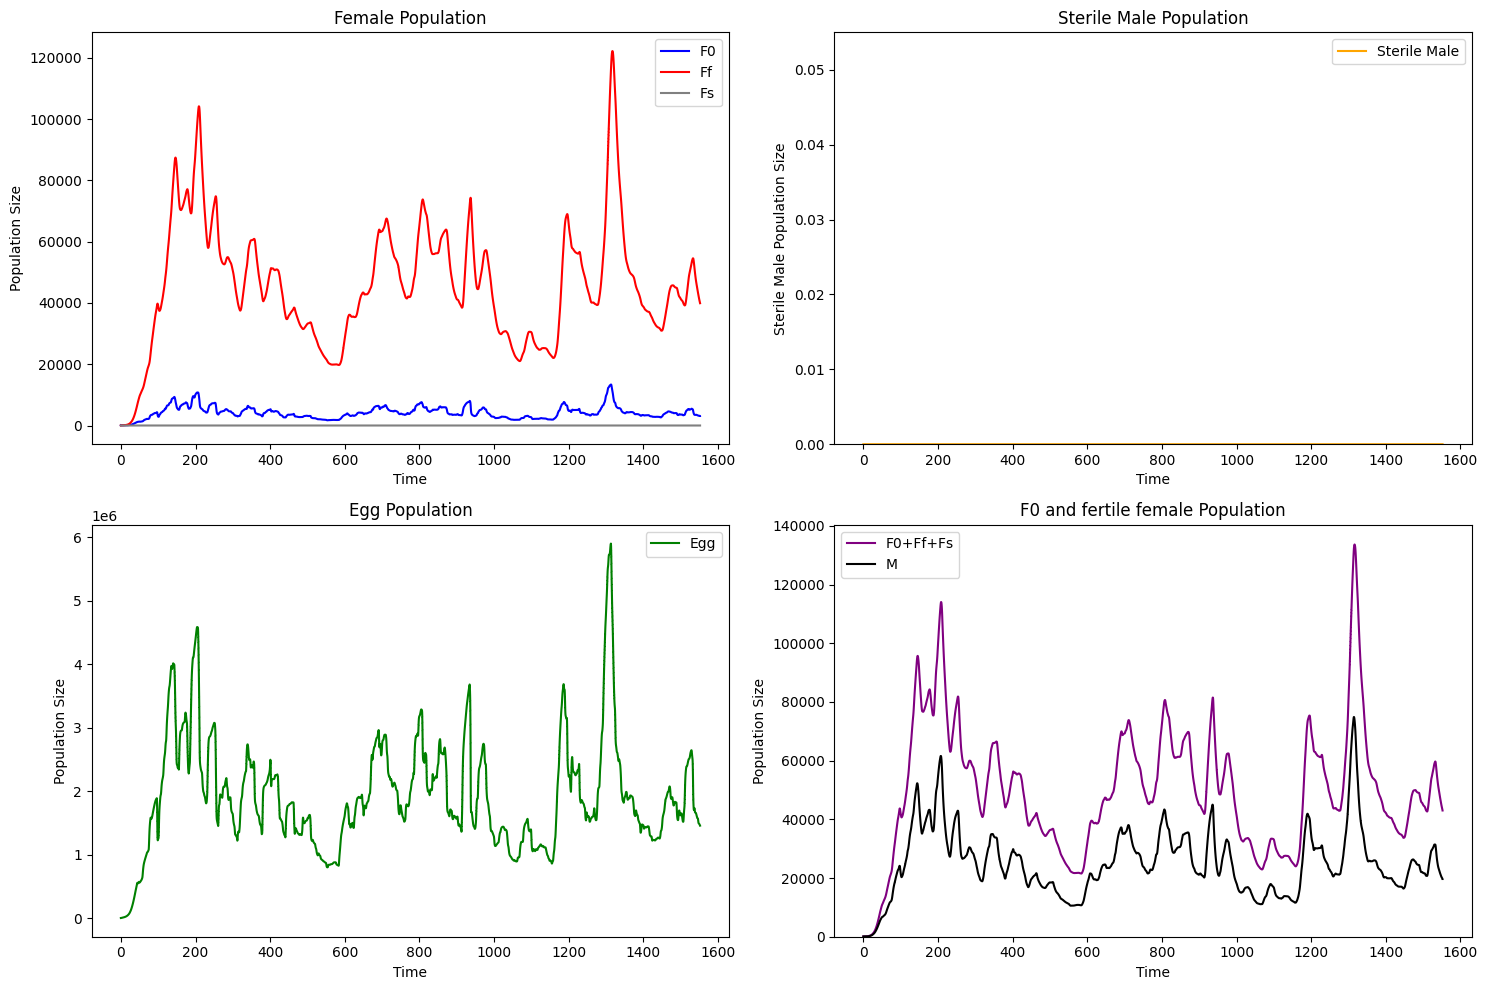

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
temp = temperature(np.array(days), 100)
# Plot results for male and female population
axs[0, 0].step(days, F, where="post", label='F0', color = 'blue')
axs[0, 0].step(days, Ff, where="post", label='Ff', color = 'red')
axs[0, 0].step(days, Fs, where="post", label='Fs', color = 'grey')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Population Size')
axs[0, 0].set_title('Female Population')
axs[0, 0].legend()

# Plot results for sterile male population
axs[0, 1].step(days, Ms, where="post", label='Sterile Male', color='orange')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Sterile Male Population Size')
axs[0, 1].set_ylim(bottom=0)
axs[0, 1].set_title('Sterile Male Population')
axs[0, 1].legend()

# Plot results for egg population
axs[1, 0].step(days, E, where="post", label='Egg', color='green')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Population Size')
axs[1, 0].set_title('Egg Population')
axs[1, 0].legend()

axs[1, 1].step(days,[F[i] + Ff[i] + Fs[i] for i in range(len(F))], where="post", label='F0+Ff+Fs', color='purple')
axs[1, 1].step(days, M, where="post", label='M', color='black')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Population Size')
axs[1, 1].set_ylim(bottom=0)
axs[1, 1].set_title('F0 and fertile female Population')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


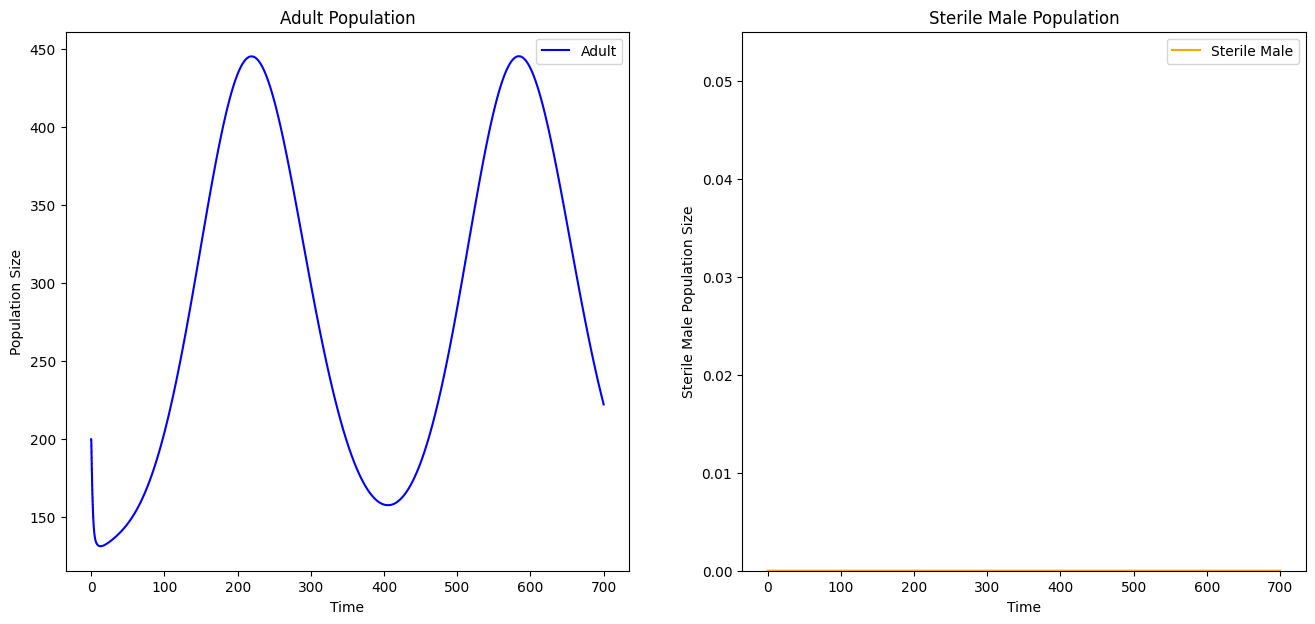

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 7))
# Plot results for male and female population
axs[0].step(days, np.array(F) + np.array(Fs) + np.array(M) + np.array(Ff), where="post", label='Adult', color = 'blue')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Population Size')
axs[0].set_title('Adult Population')
axs[0].legend()

# Plot results for sterile male population
axs[1].step(days, Ms, where="post", label='Sterile Male', color='orange')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Sterile Male Population Size')
axs[1].set_ylim(bottom=0)
axs[1].set_title('Sterile Male Population')
axs[1].legend()

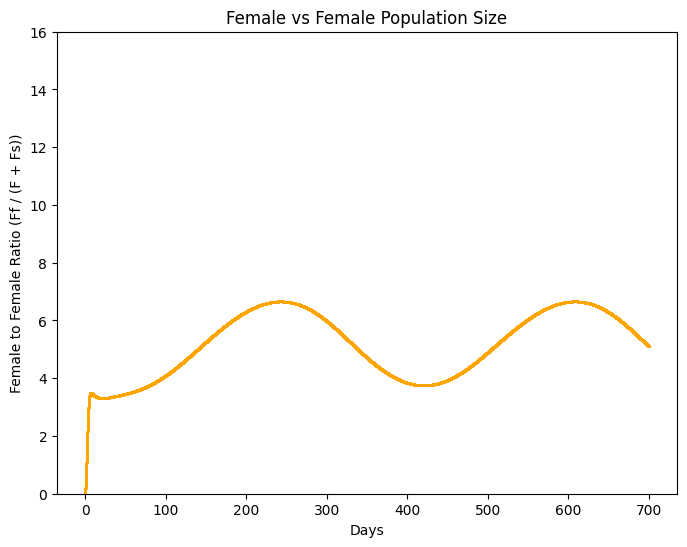

In [12]:
# plot the size of male divided by the size of female
plt.figure(figsize=(8, 6))
female_to_female_ratio = np.array(Ff) / (np.array(F) + np.array(Fs))
plt.scatter(days, female_to_female_ratio, s=1, alpha=0.5, color='orange')
#set the y-axis limits
plt.ylim(0, 16)
plt.xlabel('Days')
plt.ylabel('Female to Female Ratio (Ff / (F + Fs))')
plt.title('Female vs Female Population Size')
plt.show()


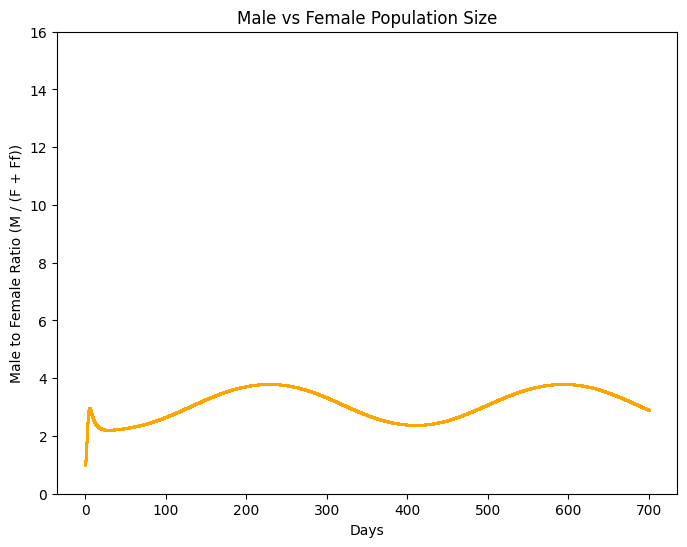

In [13]:
# plot the size of male divided by the size of female
plt.figure(figsize=(8, 6))
male_to_female_ratio = np.array(M) / (np.array(F) + np.array(Fs))
plt.scatter(days, male_to_female_ratio, s=1, alpha=0.5, color='orange')
#set the y-axis limits
plt.ylim(0, 16)
plt.xlabel('Days')
plt.ylabel('Male to Female Ratio (M / (F + Ff))')
plt.title('Male vs Female Population Size')
plt.show()


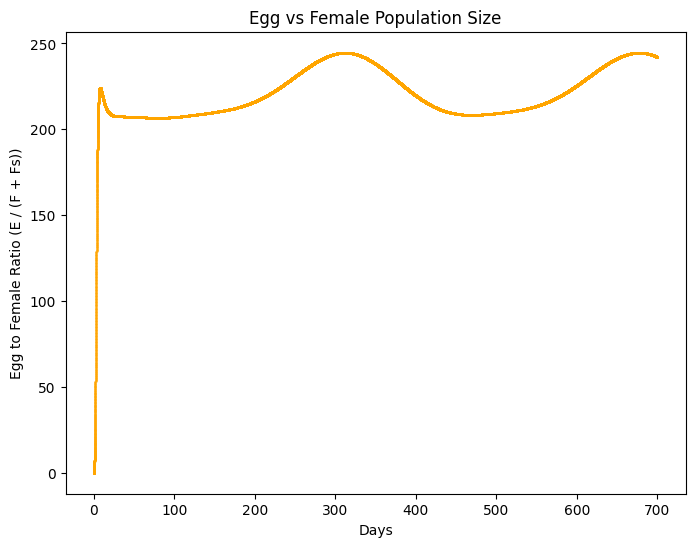

In [14]:
# plot the size of male divided by the size of female
plt.figure(figsize=(8, 6))
egg_to_female_ratio = np.array(E) / (np.array(F) + np.array(Fs))
plt.scatter(days, egg_to_female_ratio, s=1, alpha=0.5, color='orange')
#set the y-axis limits
plt.xlabel('Days')
plt.ylabel('Egg to Female Ratio (E / (F + Fs))')
plt.title('Egg vs Female Population Size')
plt.show()


# Stochastic diffusion model

## Starting from birth death process with K order rates

We introduce the gamma rates representing the behavior of the pop when big population and the proportion of each pop at equilibrium compared to the total female population. 

In [ ]:
K = 1e5
y = F[-1] + Fs[-1]
u = F[-1]/y
v = M[-1]/y
w = E[-1]/y
print(f"Final Population: K={K}, F={F[-1]}, Fs={Fs[-1]}, M={M[-1]}, E={E[-1]}")
print(f"Final Ratios: u={u:.4f}, v={v:.4f}, w={w:.4f}")

In [ ]:
gamma1 = egg_death(298)
gamma2 = deltaA
gamma4 = 2 * deltaA
gamma31 = birth
gamma23 = 1
gamma1a = adult_rate(300, R0, Ha, Hh, T12, R)

u = gamma2/(gamma23 + gamma2)
v = gamma2/gamma4
w = 2 * gamma2/gamma1a

In [ ]:
# Define the SDE function
def sde(X, coeff_drift, coeff_diff, dt):
    dX = coeff_drift * X * dt  +  np.sqrt(coeff_diff * X) * np.random.normal(0, dt)
    return dX

def sde_sim(pop, Tmax, dt, K, u, v, w, gamma1, gamma2, c):
    t = np.arange(0, Tmax, dt)
    X = np.zeros(len(t))
    #X[0] = sum(pop)/K
    X[0] = 0.25
    coeff_diff = 2 * (n_egg + 1) * (2 * gamma2 + w * gamma1) / (1 + v + w)
    for i in range(1, len(t)):
        T = temperature(t[i])
        Hum = humidity(t[i])
        comp = competition(1/c, 1/(c * 50), Hum, 60)
        transi = adult_rate(T, R0, Ha, Hh, T12, R)
        death_egg = egg_death(T) + (transition_rate(0, T, R0, Ha, Hh, T12, R) - transi)
        coeff_drift = (n_egg * birth * (1-u) - ((death_egg + comp * K * X[i-1] * w/(1 + v + w)) * w + deltaA + v * 2 * deltaA))/(1 + v + w)
        X[i] = max(0, X[i-1] + sde(X[i-1], coeff_drift, coeff_diff, dt))
    return t, X

def getpopsde(SUM, u, v, w, K) :
    Y = SUM/(1 + v + w)
    E_sde = Y * w
    F_sde = Y * u
    Ff_sde = Y * (1-u)
    M_sde = Y * v
    return K * E_sde, K * F_sde, K * Ff_sde, K * M_sde

In [ ]:
sum(pop)

In [ ]:
# simulate the SDE
t_sde, X1_sde = sde_sim(pop,  # pop
    max_time,                   # Tmax
    days[1] - days[0],        # dt
    K, u, v, w,
    gamma1, gamma2,
    comp                   # c
)

In [ ]:
plt.plot(t_sde, X1_sde)
plt.plot(days, (np.array(F) + np.array(Fs) + np.array(M) + np.array(Ff) + np.array(E))/K, label='Eggs (SDE)', color='green')

In [ ]:
E_sde, F_sde, Ff_sde, M_sde = getpopsde(X1_sde, u, v, w, K)

In [ ]:
#plot the new sde the same way the edo was

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
temp = temperature(np.array(t_sde), 100)
# Plot results for male and female population
axs[0, 0].step(t_sde, F_sde, where="post", label='F0', color = 'blue')
axs[0, 0].step(t_sde, Ff_sde, where="post", label='Ff', color = 'red')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Population Size')
axs[1, 1].set_ylim(bottom=0)
axs[0, 0].set_title('Female Population')
axs[0, 0].legend()

# Plot results for sterile male population
axs[0, 1].step(t_sde, M_sde, where="post", label='Sterile Male', color='orange')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Sterile Male Population Size')
axs[0, 1].set_ylim(bottom=0)
axs[0, 1].set_title('Sterile Male Population')
axs[0, 1].legend()

# Plot results for egg population
axs[1, 0].step(t_sde, E_sde, where="post", label='Egg', color='green')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Population Size')
axs[1, 1].set_ylim(bottom=0)
axs[1, 0].set_title('Egg Population')
axs[1, 0].legend()

axs[1, 1].step(t_sde,[F_sde[i] + Ff_sde[i] for i in range(len(F_sde))], where="post", label='F0+Ff', color='purple')
axs[1, 1].step(t_sde, M_sde, where="post", label='M', color='black')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Population Size')
axs[1, 1].set_ylim(bottom=0, top = 40000)
axs[1, 1].set_title('F0 and fertile female Population')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


In [ ]:
# Plot the respective populations sde and edo
plt.figure(figsize=(10, 6))
plt.plot(days, F, label='F0 (EDO)', color='blue', linestyle='--')
plt.plot(t_sde, F_sde, label='F0 (SDE)', color='cyan', alpha=0.5)
plt.plot(days, Ff, label='Ff (EDO)', color='red', linestyle='--')
plt.plot(t_sde, Ff_sde, label='Ff (SDE)', color='orange', alpha=0.5)
plt.plot(days, M, label='M (EDO)', color='black', linestyle='--')
plt.plot(t_sde, M_sde, label='M (SDE)', color='grey', alpha=0.5)

plt.xlabel('Days')
plt.ylabel('Population Size')
plt.title('Comparison of EDO and SDE Populations')
plt.legend()
plt.show()

## Other method

In [ ]:
# Parameters
birth = 0.5  # Birth rate per adult
puberty = 0.83      # transition rate from egg to adult
mu = 0.5    # rate at which egg becomes a female
deltaE = 0.2     # Death rate per egg
deltaA = 0.091  # Death rate per adult
init_egg = 100  # Starting egg population
init_f0 = 100 # Starting female population
init_ff = 0 # Starting fertilised female pop
init_fs = 0 # Starting strerile female pop
init_male = 100 # Starting adult population
init_sterile = 0 # Starting sterile male population
max_time = 500.0     # Maximum simulation time
comp = 0.0001 # Carrying capacity

R0 = [0.24, 0.2088, 0.384]
Hh = [100, 55.99, -472.379]
Ha = [10.798, 26.018, 14.931]
T12 = [14.184, 304.6, 148]
R = 8.31446261815324 # Universal gas constant

n = 100000
T = 1000
dt = T/n
n_egg = 64
K = 100
days = np.linspace(0, 1000, n+1)  # Time steps

In [ ]:
def vect_event(X, birth, t, deltaA, comp, mu, R0, Ha, Hh, T12, R):
    E, F, Ff, Fs, M, Ms = X
    T = temperature(t, 100)
    if T < 286:
        death_egg = 0.001
        transi = 0
    else:
        transi = adult_rate(T, R0, Ha, Hh, T12, R)
        death_egg = egg_death(T) + comp * E + (transition_rate(0, T, R0, Ha, Hh, T12, R) - transi)
    
    matf = mating(0.01*M, 0.001*Ms)
    if M + Ms == 0:
        probaM = 0
    else:
        probaM = M / (2 * M + Ms)

    # Differential equations
    evt = [math.sqrt(birth * Ff), 
        math.sqrt(death_egg * E),
        math.sqrt(mu * transi * E),
        math.sqrt((1 - mu) * transi * E),
        math.sqrt(matf * 2 * probaM * F),
        math.sqrt(deltaA * F),
        math.sqrt(deltaA * M),
        math.sqrt(deltaA * Ff)]
    return evt

def sqrt_diff_mat(evt, Mat):
    M = np.zeros((4, 4))
    for i in range(len(evt)) : 
        v = Mat[i].reshape(4,1)
        M += evt[i] * np.dot(v, v.transpose())
    S = np.linalg.cholesky(M)
    return S

def update_sto(New, Mat_sqrt, BM):
    # Update the state vector using the square root of the covariance matrix
    dX = np.dot(Mat_sqrt, BM)
    New[0] += dX[0]
    New[1] += dX[1]
    New[2] += dX[2]
    New[4] += dX[3]
    return New

In [ ]:
# Using euler's scheme to solve the differential equations

X = np.array([np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1)])
X[:, 0] = [init_egg, init_f0, init_ff, init_fs, init_male, init_sterile]
print(X[:, 0])

M_evt = np.array([[n_egg, 0, 0, 0],
              [-1, 0, 0, 0],
              [-1, 1, 0, 0],
              [-1, 0, 1, 0],
              [0, -1, 0, 1],
              [0, -1, 0, 0],
              [0, 0, -1, 0],
              [0, 0, 0, -1]])

N = np.zeros(6)
# Do 7 releases starting day 450 with a week interval
release = np.array([(750 + 7*i)/dt for i in range(0, 12)])

for i in range(0,n):
    N = np.zeros(6)
    rel = [0,0,0,0,0,0]
    v_evt = vect_event(X[:, i], i*dt, birth, deltaA, comp, mu, R0, Ha, Hh, T12, R)
    B = np.random.normal(0, math.sqrt(dt), 4)
    M = sqrt_diff_mat(v_evt, M_evt)
    N = update_sto(N, M, B)
    det = np.array(det_model(X[:, i], i*dt, birth, n_egg, deltaA, comp, mu, R0, Ha, Hh, T12, R))*dt
    if i in release and X[4, i] > 1 and 4 == 5:
        print("release of ",  50*(X[3, i] + X[4, i]) + 2000, 'mosquitoes at time ', i*dt)
        rel = [0, 0, 0, 0, 0, 50*(X[3, i] + X[4, i]) + 2000]
        
    X[:, i+1] = np.maximum(X[:, i] + det + N * 1/math.sqrt(K) + rel, 0)
    if X[2, i+1] + X[0, i+1]== 0:
        print("No more fertilised females at time ", i*dt)
        break

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
temp = temperature(np.array(days), 100)
# Plot results for male and female population
axs[0, 0].step(days, X[1], where="post", label='F0', color = 'blue')
axs[0, 0].step(days, X[2], where="post", label='Ff', color = 'red')
axs[0, 0].step(days, X[3], where="post", label='Fs', color = 'grey')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Population Size')
axs[0, 0].set_title('Female Population')
axs[0, 0].legend()

# Plot results for sterile male population
axs[0, 1].step(days, X[5], where="post", label='Sterile Male', color='orange')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Sterile Male Population Size')
axs[0, 1].set_ylim(bottom=0)
axs[0, 1].set_title('Sterile Male Population')
axs[0, 1].legend()

# Plot results for egg population
axs[1, 0].step(days, X[0], where="post", label='Egg', color='green')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Population Size')
axs[1, 0].set_title('Egg Population')
axs[1, 0].legend()

axs[1, 1].step(days, X[1] + X[2] + X[3], where="post", label='F0+Ff+Fs', color='purple')
axs[1, 1].step(days, X[4], where="post", label='M', color='black')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Population Size')
axs[1, 1].set_ylim(bottom=0)
axs[1, 1].set_title('F0 and fertile female Population')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


In [ ]:
def mating(M, Ms):
    return M / (1 + M + Ms)

def matingd1(U, V, u, v):
    return (u + u*v*V )/ (1 + u*U + v*V)**2

def matingd2(U, V, u, v):
    return - (u*v*U )/ (1 + u*U + v*V)**2


In [ ]:
def Jac_Mat(X, birth, t, deltaA, comp, mu, R0, Ha, Hh, T12, R):
    E, F, Ff, Fs, M, Ms = X
    T = temperature(t, 100)
    if T < 286:
        death_egg = 0.001
        transi = 0
    else:
        transi = adult_rate(T, R0, Ha, Hh, T12, R)
        death_egg = egg_death(T) + comp * E + (transition_rate(0, T, R0, Ha, Hh, T12, R) - transi)
    
    matf = mating(0.01*M, 0.001*Ms)
    mats = mating(0.001*Ms, 0.01*M)

    d11 = matingd1(M, Ms, 0.01, 0.001)
    d12 = matingd2(M, Ms, 0.01, 0.001)

    d21 = matingd1(Ms, M, 0.001, 0.01)
    d22 = matingd2(Ms, M, 0.001, 0.01)

    # Jacobian matrix
    Jacobian = [[-(death_egg + transi), 0, birth, 0, 0, 0],
           [mu*transi, -deltaA - matf - mats, 0, 0, - d11 - d21, -d12 - d22],
        [0, matf, -deltaA, 0, d11, d12],
        [0, mats, 0, -deltaA, d21, d22],
        [(1 - mu)*transi, 0, 0, 0, -deltaA, 0],
        [0, 0, 0, 0, 0, -deltaA*1.5]]
    return Jacobian

In [ ]:
# Using euler's scheme to solve the differential equations
X = np.array([np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1)])
X[:, 0] = [init_egg, init_f0, init_ff, init_fs, init_male, init_sterile]
V = np.array([np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1)])
V[:, 0] = [100, 100, 0, 100, 100, 0]
print(X[:, 0])
print(V[:, 0])

M = np.array([[n_egg, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, -1, -1, -1, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0, -1, 0, 0, 0],
              [0, 0, 0, 0, 0, 1, 0, 0, -1, 0, 0],
              [0, 0, 0, 1, 0, 0, 0, 0, 0, -1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]])

for i in range(0,n):
    N = np.zeros(6)
    x = X[:, i] + np.array(det_model(X[:, i], i*dt, birth, n_egg, deltaA, comp, mu, R0, Ha, Hh, T12, R))*dt
    J = Jac_Mat(x, birth, i*dt, deltaA, comp, mu, R0, Ha, Hh, T12, R)
    U = vect_event(x, i*dt, birth, deltaA, comp, mu, R0, Ha, Hh, T12, R)
    B = np.array(U) * np.random.normal(0, math.sqrt(dt), 8)
    N = np.dot(M, B)
    V[:, i+1] = V[:, i] + np.dot(J, V[:, i])*dt + N
    X[:, i+1] = np.maximum(x + V[:, i+1] / math.sqrt(K), 0)
    if sum(X[:, i+1]) == 0:
        break

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
temp = temperature(np.array(days), 100)
# Plot results for male and female population
axs[0, 0].step(days, X[1], where="post", label='F0', color = 'blue')
axs[0, 0].step(days, X[2], where="post", label='Ff', color = 'red')
axs[0, 0].step(days, X[3], where="post", label='Fs', color = 'grey')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Population Size')
axs[0, 0].set_title('Female Population')
axs[0, 0].legend()

# Plot results for sterile male population
axs[0, 1].step(days, X[5], where="post", label='Sterile Male', color='orange')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Sterile Male Population Size')
axs[0, 1].set_ylim(bottom=0)
axs[0, 1].set_title('Sterile Male Population')
axs[0, 1].legend()

# Plot results for egg population
axs[1, 0].step(days, X[0], where="post", label='Egg', color='green')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Population Size')
axs[1, 0].set_title('Egg Population')
axs[1, 0].legend()

axs[1, 1].step(days, X[1] + X[2] + X[3], where="post", label='F0+Ff+Fs', color='purple')
axs[1, 1].step(days, X[4], where="post", label='M', color='black')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Population Size')
axs[1, 1].set_ylim(bottom=0)
axs[1, 1].set_title('F0 and fertile female Population')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
temp = temperature(np.array(days), 100)
# Plot results for male and female population
axs[0, 0].step(days, V[1], where="post", label='F0', color = 'blue')
axs[0, 0].step(days, V[2], where="post", label='Ff', color = 'red')
axs[0, 0].step(days, V[3], where="post", label='Fs', color = 'grey')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Population Size')
axs[0, 0].set_title('Female Population')
axs[0, 0].legend()

# Plot results for sterile male population
axs[0, 1].step(days, V[5], where="post", label='Sterile Male', color='orange')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Sterile Male Population Size')
axs[0, 1].set_title('Sterile Male Population')
axs[0, 1].legend()

# Plot results for egg population
axs[1, 0].step(days, V[0], where="post", label='Egg', color='green')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Population Size')
axs[1, 0].set_title('Egg Population')
axs[1, 0].legend()

axs[1, 1].step(days, V[1] + V[2] + V[3], where="post", label='F0+Ff+Fs', color='purple')
axs[1, 1].step(days, V[4], where="post", label='M', color='black')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Population Size')
axs[1, 1].set_title('F0 and fertile female Population')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
results = []
# Iterate 10 times
for iteration in range(30):
    X = np.array([np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1)])
    X[:, 0] = [init_egg, init_f0, init_ff, init_fs, init_male, init_sterile]
    V = np.array([np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1)])
    
    for i in range(n):
        J = Jac_Mat(X[:, i], birth, i*dt, deltaA, comp, mu, R0, Ha, Hh, T12, R)
        U = vect_event(X[:, i], i*dt, birth, deltaA, comp, mu, R0, Ha, Hh, T12, R)
        B = np.array(U) * np.random.normal(0, math.sqrt(dt), 11)
        N = np.dot(M, B)
        V[:, i+1] = V[:, i] + np.dot(J, V[:, i])*dt + N
        X[:, i+1] = np.maximum(X[:, i] + np.array(det_model(X[:, i], i*dt, birth, n_egg, deltaA, comp, mu, R0, Ha, Hh, T12, R))*dt + V[:, i+1] * 1/math.sqrt(K), 0)
        if sum(X[:, i+1]) == 0:
            break
    
    results.append(X)


In [ ]:

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i in range(30):
    X = results[i]
    # Plot results for female population
    axs[0, 0].step(days, X[1], where="post",  color='blue', alpha=0.3)
    axs[0, 0].step(days, X[2], where="post",  color='red', alpha=0.3)
    axs[0, 0].step(days, X[3], where="post",  color='grey', alpha=0.3)
    
    # Plot results for sterile male population
    axs[0, 1].step(days, X[5], where="post",  color='orange', alpha=0.3)
    
    # Plot results for egg, with different colors for each iteration
    axs[1, 0].step(days, X[0], where="post", color=plt.cm.viridis(i / 20), alpha=1) 
    
    # Plot results for combined female and male population
    axs[1, 1].step(days, X[1] + X[2] + X[3], where="post", color='purple', alpha=0.3)
    axs[1, 1].step(days, X[4], where="post",  color='black', alpha=0.3)

# Set titles and labels
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Population Size')
axs[0, 0].set_title('Female Population')
axs[0, 0].legend()

axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Sterile Male Population Size')
axs[0, 1].set_ylim(bottom=0)
axs[0, 1].set_title('Sterile Male Population')
axs[0, 1].legend()

axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Population Size')
axs[1, 0].set_title('Egg Population')
axs[1, 0].legend()

axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Population Size')
axs[1, 1].set_ylim(bottom=0)
axs[1, 1].set_title('Combined Female and Male Population')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

# Using the generator

Not biologically rigorous

In [ ]:
gamma = 1

In [ ]:
# Using euler's scheme to solve the differential equations

X = np.array([np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1)])
X[:, 0] = [init_egg, init_f0, init_ff, init_fs, init_male, init_sterile]
print(X[:, 0])

for i in range(0,n):
    #U = vect_event(X[:, i], i*dt, birth, deltaA, comp, mu, R0, Ha, Hh, T12, R)
    B = np.sqrt(np.array(X[:,i])*2*gamma) * np.random.normal(0, math.sqrt(dt), 6)*np.array([2,1,1,0,1,0])
    X[:, i+1] = np.maximum(X[:, i] + np.array(det_model(X[:, i], i*dt, birth, n_egg, deltaA, comp, mu, R0, Ha, Hh, T12, R))*dt + B,0)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
temp = temperature(np.array(days), 100)
# Plot results for male and female population
axs[0, 0].step(days, X[1], where="post", label='F0', color = 'blue')
axs[0, 0].step(days, X[2], where="post", label='Ff', color = 'red')
axs[0, 0].step(days, X[3], where="post", label='Fs', color = 'grey')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Population Size')
axs[0, 0].set_title('Female Population')
axs[0, 0].legend()

# Plot results for sterile male population
axs[0, 1].step(days, X[5], where="post", label='Sterile Male', color='orange')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Sterile Male Population Size')
axs[0, 1].set_ylim(bottom=0)
axs[0, 1].set_title('Sterile Male Population')
axs[0, 1].legend()

# Plot results for egg population
axs[1, 0].step(days, X[0], where="post", label='Egg', color='green')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Population Size')
axs[1, 0].set_title('Egg Population')
axs[1, 0].legend()

axs[1, 1].step(days, X[1] + X[2] + X[3], where="post", label='F0+Ff+Fs', color='purple')
axs[1, 1].step(days, X[4], where="post", label='M', color='black')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Population Size')
axs[1, 1].set_ylim(bottom=0)
axs[1, 1].set_title('F0 and fertile female Population')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


In [ ]:
# Do the previous method 30 times
results = []
for iteration in range(30):
    X = np.array([np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1)])
    X[:, 0] = [init_egg, init_f0, init_ff, init_fs, init_male, init_sterile]
    for i in range(0,n):
    #U = vect_event(X[:, i], i*dt, birth, deltaA, comp, mu, R0, Ha, Hh, T12, R)
        B = np.sqrt(np.array(X[:,i])*2*gamma) * np.random.normal(0, math.sqrt(dt), 6)*np.array([2,1,1,0,1,0])
        X[:, i+1] = np.maximum(X[:, i] + np.array(det_model(X[:, i], i*dt, birth, n_egg, deltaA, comp, mu, R0, Ha, Hh, T12, R))*dt + B,0)
    results.append(X)

In [ ]:
# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i in range(30):
    X = results[i]
    # Plot results for female population
    axs[0, 0].step(days, X[1], where="post",  color='blue', alpha=0.3)
    axs[0, 0].step(days, X[2], where="post",  color='red', alpha=0.3)
    axs[0, 0].step(days, X[3], where="post",  color='grey', alpha=0.3)
    
    # Plot results for sterile male population
    axs[0, 1].step(days, X[5], where="post",  color='orange', alpha=0.3)
    
    # Plot results for egg, with different colors for each iteration
    axs[1, 0].step(days, X[0], where="post", color=plt.cm.viridis(i / 20), alpha=1) 
    
    # Plot results for combined female and male population
    axs[1, 1].step(days, X[1] + X[2] + X[3], where="post", color='purple', alpha=0.3)
    axs[1, 1].step(days, X[4], where="post",  color='black', alpha=0.3)

# Set titles and labels
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Population Size')
axs[0, 0].set_title('Female Population')
axs[0, 0].legend()

axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Sterile Male Population Size')
axs[0, 1].set_ylim(bottom=0)
axs[0, 1].set_title('Sterile Male Population')
axs[0, 1].legend()

axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Population Size')
axs[1, 0].set_title('Egg Population')
axs[1, 0].legend()

axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Population Size')
axs[1, 1].set_ylim(bottom=0)
axs[1, 1].set_title('Combined Female and Male Population')
axs[1, 1].legend()

plt.tight_layout()
plt.show()